<a href="https://colab.research.google.com/github/jossy450/assignment/blob/main/%5BNAME%5D_%5BID%5D_ADS2_Assignment_2_Data_Handling_and_Processing_with_PySpark_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS2 - Assignment 2 - Data Handling and Processing with PySpark

In this assignment, you will be analysing the popularity of films and TV shows on the streaming platform, Netflix. Using your knowledge of PySpark DataFrames and Spark SQL, you will produce a number of "downstream" data products to analyse trends in global streaming habits.

Download the dataset from this [Kaggle](https://www.kaggle.com/dhruvildave/netflix-top-10-tv-shows-and-films) page. A copy of the `all_weeks_countries.csv` file is also available on the canvas page for this assignment.

Your task is to load in the data and produce a number of "downstream" data products and plots as described below.

The PySpark installation and setup is provided below for conveinience.

In [19]:
# Apache Spark uses Java, so first we must install that
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [20]:
# Mount Google Drive and unpack Spark
from google.colab import drive
drive.mount('/content/drive')
!tar xzf /content/drive/MyDrive/spark-3.3.0-bin-hadoop3.tgz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

In [22]:
# Install findspark, which helps python locate the psyspark module files
!pip install pyspark
!pip install -q findspark
import findspark
findspark.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
# Finally, we initialse a "SparkSession", which handles the computations
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Exercise 1 - Data Preparation (5 Marks)


1.   Load the `all_weeks_countries.csv` into your Colab Notebook as a DataFrame.
2.   Create two separate DataFrames for Films and TV.
3.   For the Films data, drop the column containing the season names.
4.   For the TV data, replace any null values in the season name column with the show name.

In [24]:
# pyspark.sql.functions countains all the transformations and actions you will
# need
from pyspark.sql import functions as F

In [25]:
### Load the all_weeks_countries.csv into your Colab Notebook as a DataFrame.

# Load the CSV file into a DataFrame

spark = SparkSession.builder.appName("Load CSV").getOrCreate()
data = spark.read.csv('/content/drive/MyDrive/all-weeks-countries.csv', header=True, inferSchema=True)





In [26]:
### Display the table and its schema

# Display the DataFrame
data.show()

# Display the schema of the DataFrame
data.printSchema()


+------------+------------+-------------------+--------+-----------+--------------------+--------------------+--------------------------+
|country_name|country_iso2|               week|category|weekly_rank|          show_title|        season_title|cumulative_weeks_in_top_10|
+------------+------------+-------------------+--------+-----------+--------------------+--------------------+--------------------------+
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          1|      Look Both Ways|                null|                         1|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          2|           Day Shift|                null|                         2|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          3|Bank Robbers: The...|                null|                         2|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          4|   The Next 365 Days|                null|                         1|
|   Argentina|          AR|2022-08

In [29]:
### Seperate the data into two DataFrames for Films and TV

films = data.filter(data.category == 'Films')
tvs = data.filter(data.category == 'TV')

In [30]:
### Drop the 'season_title' column from the Films DataFrame, display the table

films = films.drop('season_title')

# display the updated DataFrame
films.show(20)


+------------+------------+-------------------+--------+-----------+--------------------+--------------------------+
|country_name|country_iso2|               week|category|weekly_rank|          show_title|cumulative_weeks_in_top_10|
+------------+------------+-------------------+--------+-----------+--------------------+--------------------------+
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          1|      Look Both Ways|                         1|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          2|           Day Shift|                         2|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          3|Bank Robbers: The...|                         2|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          4|   The Next 365 Days|                         1|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|          5|The Angry Birds M...|                         1|
|   Argentina|          AR|2022-08-21 00:00:00|   Films|        

In [31]:
### Replace any null values in 'season_name' in the TV DataFrame with the
### corresponding 'show_name', display the table


tvs = tvs.fillna(("show_title"), subset=["season_title"])
tvs.show()

+------------+------------+-------------------+--------+-----------+--------------------+--------------------+--------------------------+
|country_name|country_iso2|               week|category|weekly_rank|          show_title|        season_title|cumulative_weeks_in_top_10|
+------------+------------+-------------------+--------+-----------+--------------------+--------------------+--------------------------+
|   Argentina|          AR|2022-08-21 00:00:00|      TV|          1| Pasión de Gavilanes|Pasión de Gavilan...|                         5|
|   Argentina|          AR|2022-08-21 00:00:00|      TV|          2|        Another Self|Another Self: Sea...|                         4|
|   Argentina|          AR|2022-08-21 00:00:00|      TV|          3| Pasión de Gavilanes|Pasión de Gavilan...|                        58|
|   Argentina|          AR|2022-08-21 00:00:00|      TV|          4|            Manifest|  Manifest: Season 1|                         6|
|   Argentina|          AR|2022-08

# Exercise 2 - Most popular films by country (10 Marks)

1.   For each country in the data, find the highest rank each film reached, and the number of weeks it spent in the top 10. (4 marks)
2.   Produce a DataFrame that contains the film which spent the most time in each country's top 10. (4 marks)
3.   Produce a pie chart which shows how many countries the most popular films occurred in. (2 marks)


In [32]:
### Group the data by 'country_name' and 'show_title' and find the highest
### weekly rank and total weeks spent in the top 10 for each film, display the
### data
# .groupBy, .agg, F.max, F.min, .sort, .show


# Group the data by 'country_name' and 'show_title' and find the highest weekly rank and total weeks spent in the top 10 for each film
grouped_film = films.groupBy(['country_name', 'show_title']) \
            .agg(F.min('weekly_rank'), \
                 F.max('cumulative_weeks_in_top_10')) \
            .sort(['country_name', 'show_title'], ascending=[1, 1])

# Display the data
grouped_film.show()

+------------+--------------------+----------------+-------------------------------+
|country_name|          show_title|min(weekly_rank)|max(cumulative_weeks_in_top_10)|
+------------+--------------------+----------------+-------------------------------+
|   Argentina|13 Hours: The Sec...|               4|                              2|
|   Argentina|                1917|               3|                              2|
|   Argentina|                 211|               4|                              1|
|   Argentina|  365 Days: This Day|               1|                              2|
|   Argentina|      40 Years Young|               8|                              1|
|   Argentina|47 Meters Down: U...|               5|                              2|
|   Argentina|         7 Prisoners|               5|                              2|
|   Argentina|A Boy Called Chri...|               6|                              2|
|   Argentina|A California Chri...|               4|             

Produce a DataFrame which shows, for each country, the most popular film by the number of weeks it spent in the top 10, how many weeks that film was in the top 10, and the highest weekly rank it reached.

In [33]:
### Find the film that spent the most time in each country's top 10 list.
### Produce and display a table showing that information, along with the number
### of weeks spent in the top 10, and the highest weekly ranking
# .groupBy, .sort, .desc, .agg, F.first, .show

# group the data by country and show, and aggregate the maximum number of weeks spent in the top 10 and the highest weekly ranking
weekly_top = films.groupBy(['country_name', 'show_title']) \
                .agg(F.max('cumulative_weeks_in_top_10'), 
                     F.min('weekly_rank'))\
                     .sort(['country_name', F.col('max(cumulative_weeks_in_top_10)').desc()]) \
                        .groupBy('country_name').agg(F.first('show_title'), 
                                                    F.first('max(cumulative_weeks_in_top_10)').alias('total_weeks_in_top_10'), 
                                                    F.first('min(weekly_rank)').alias('highest_rank'))

# display the resulting table
weekly_top.show()



+------------------+--------------------+---------------------+------------+
|      country_name|   first(show_title)|total_weeks_in_top_10|highest_rank|
+------------------+--------------------+---------------------+------------+
|         Argentina|  Sonic the Hedgehog|                    7|           1|
|         Australia| Back to the Outback|                    8|           2|
|           Austria|Harry Potter and ...|                    9|           2|
|           Bahamas|  A Madea Homecoming|                    9|           1|
|           Bahrain|          Red Notice|                    8|           1|
|        Bangladesh|        Sooryavanshi|                   21|           1|
|           Belgium|    The Adam Project|                    8|           1|
|           Bolivia|               Shrek|                   18|           6|
|            Brazil|Hotel Transylvani...|                    7|           2|
|          Bulgaria|          Red Notice|                   15|           1|

Group the DataFrame by `season_title` and count the number of countries where each season is the most popular. Convert the DataFrame to Pandas, and use the `DataFrame.plot.pie` method to produce a pie chart of the most popular shows.

+--------------------+-------------+
|        season_title|country_count|
+--------------------+-------------+
|I am Solo: Part 5...|            1|
|  Vincenzo: Season 1|            2|
|Squid Game: Season 1|           17|
|Café con aroma de...|            2|
| Money Heist: Part 5|            1|
|     Ozark: Season 4|            1|
|Carinha de Anjo: ...|            1|
|SpongeBob SquareP...|            4|
|Hometown Cha-Cha-...|            3|
| CoComelon: Season 3|            1|
|The Good Doctor: ...|           10|
|The Promise: Seas...|            1|
|   Stranger Things 4|           13|
|Pablo Escobar, el...|            5|
|The Good Doctor: ...|            1|
|Crash Landing on ...|            2|
|Resurrection: Ert...|            1|
|The Queen of Flow...|            3|
|          show_title|            2|
|   Friends: Season 6|            1|
+--------------------+-------------+
only showing top 20 rows



<Axes: title={'center': 'Most Popular Shows by Season'}, ylabel='country_count'>

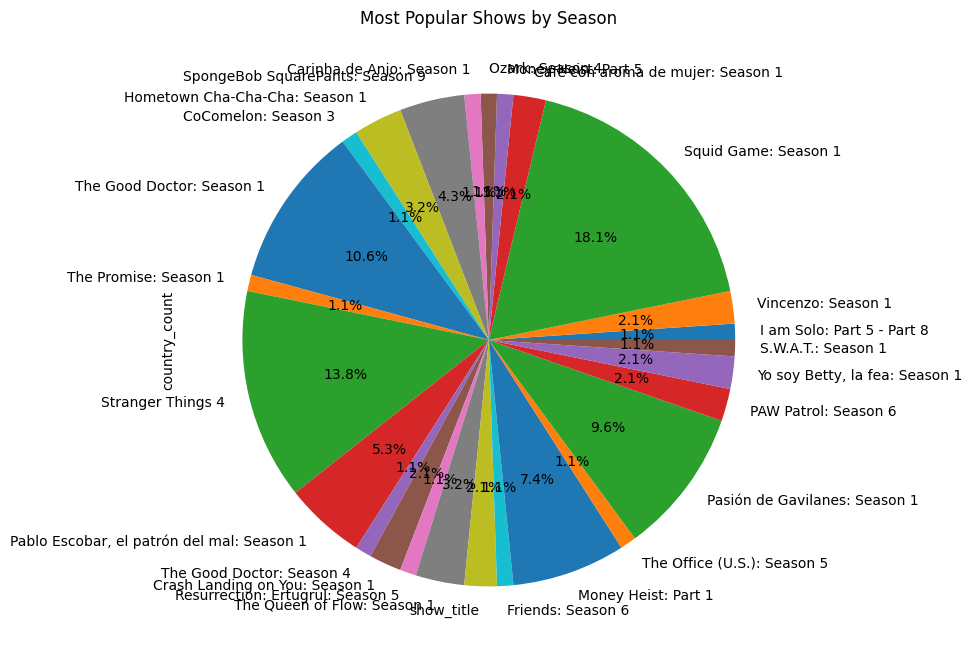

In [37]:
# group the data by country and show, and aggregate the maximum number of weeks spent in the top 10 and the highest weekly ranking
movie_count = tvs.groupBy(['country_name', 'season_title']) \
                .agg(F.max('cumulative_weeks_in_top_10').alias('max_weeks_in_top_10'), 
                     F.min('weekly_rank').alias('highest_weekly_rank'))\
                     .sort(['country_name', F.col('max_weeks_in_top_10').desc()]) \
                        .groupBy('country_name').agg(F.first('season_title').alias('season_title'), 
                                                    F.first('max_weeks_in_top_10').alias('max_weeks_in_top_10'), 
                                                    F.first('highest_weekly_rank').alias('highest_weekly_rank'))\
                                                    .groupBy('season_title').agg(F.count('country_name').alias('country_count'))

movie_count.show()

# Convert the DataFrame to Pandas
movie_count_pd = movie_count.toPandas()
# Convert the count column to int
movie_count_pd['country_count'] = movie_count_pd['country_count'].astype(int)

# Plot a pie chart
movie_count_pd.plot.pie(y='country_count', labels= movie_count_pd['season_title'], legend=False, autopct='%1.1f%%', figsize=(8, 8), title='Most Popular Shows by Season')

# Exercise 3 - Most popular shows by country (10 Marks)


1.   Calculate the number of weeks each TV show spent in each country's top 10, across all seasons, such that you don't double count a show when two or more seasons appear in one week. (5 marks)
2.   Produce a DataFrame that contains the show which spent the most time in each country's top 10. (5 marks)

In [38]:
### Group the data by 'country_name' and 'show_title' and count the number of
### weeks each show appears in each country's top 10 lists, as well as the
### highest weekly ranking. Display the data.
# .groupBy, .agg, F.count_distinct, F.min, .sort, .show

grouped_data = tvs.groupBy("country_name", "show_title").agg(
    F.count_distinct("cumulative_weeks_in_top_10").alias("num_weeks_in_top_10"),
    F.min("weekly_rank").alias("highest_weekly_ranking")
)

sorted_data = grouped_data.sort("country_name", "show_title", "highest_weekly_ranking")
sorted_data.show()


+------------+--------------------+-------------------+----------------------+
|country_name|          show_title|num_weeks_in_top_10|highest_weekly_ranking|
+------------+--------------------+-------------------+----------------------+
|   Argentina| 42 Days of Darkness|                  2|                     8|
|   Argentina|AlRawabi School f...|                  2|                     9|
|   Argentina|                Alba|                  5|                     1|
|   Argentina| Alice in Borderland|                  1|                     8|
|   Argentina|  All of Us Are Dead|                  6|                     2|
|   Argentina|        Almost Happy|                  2|                     5|
|   Argentina|Anatomy of a Scandal|                  3|                     2|
|   Argentina|        Another Self|                  4|                     2|
|   Argentina|              Arcane|                  3|                     3|
|   Argentina|          Archive 81|                 

In [39]:
### Find the show that spent the most time in each country's top 10 list.
### Produce and display a table showing that information, along with the number
### of weeks spent in the top 10, and the highest weekly ranking
# .groupBy, .sort, .desc, .agg, F.first, .show

country_lead = tvs.groupBy(['country_name', 'show_title']) \
                .agg(F.max('cumulative_weeks_in_top_10').alias('max_weeks_in_top_10'), 
                     F.min('weekly_rank').alias('highest_weekly_rank'))\
                     .sort(['country_name', F.col('max_weeks_in_top_10').desc()]) \
                        .groupBy('country_name').agg(F.first('show_title').alias('show_title'), 
                                                    F.first('max_weeks_in_top_10').alias('max_weeks_in_top_10'), 
                                                    F.first('highest_weekly_rank').alias('highest_weekly_rank'))

# display the resulting table
country_lead.show()


+------------------+--------------------+-------------------+-------------------+
|      country_name|          show_title|max_weeks_in_top_10|highest_weekly_rank|
+------------------+--------------------+-------------------+-------------------+
|         Argentina| Pasión de Gavilanes|                 58|                  1|
|         Australia|     Stranger Things|                 13|                  1|
|           Austria|     The Good Doctor|                 14|                  2|
|           Bahamas|SpongeBob SquareP...|                 33|                  3|
|           Bahrain|          Squid Game|                 16|                  1|
|        Bangladesh|          Squid Game|                 22|                  1|
|           Belgium|     Stranger Things|                 13|                  1|
|           Bolivia| Pasión de Gavilanes|                 57|                  1|
|            Brazil|         Chiquititas|                 51|                  2|
|          Bulga